In [3]:
# 1. Setup and Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import os
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import tempfile
import shutil
import zipfile
import requests
import matplotlib.pyplot as plt

# For BLEU evaluation
try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
except ImportError:
    print("NLTK not found. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "nltk"])
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download NLTK data if not already present
print("Setting up NLTK resources...")
try:
    # Test if tokenization works
    from nltk.tokenize import word_tokenize
    word_tokenize("test")
    print("NLTK tokenization ready")
except Exception as e:
    print(f"NLTK setup needed: {e}")
    try:
        print("Downloading punkt...")
        nltk.download('punkt', quiet=True)
        print("Downloading punkt_tab...")
        nltk.download('punkt_tab', quiet=True)
        print("NLTK resources downloaded")
        # Test again
        from nltk.tokenize import word_tokenize
        word_tokenize("test")
        print("NLTK tokenization now working")
    except Exception as download_error:
        print(f"NLTK download failed: {download_error}")
        print("Please run manually: python -m nltk.downloader punkt punkt_tab")

# --- Configuration ---
class Config:
    DATA_DIR = 'flickr8k'
    IMAGES_DIR = os.path.join(DATA_DIR, 'Flicker8k_Dataset')
    CAPTIONS_FILE = os.path.join(DATA_DIR, 'Flickr8k.token.txt')

    CACHED_FEATURES_DIR = 'cached_features'

    EMBED_SIZE = 512
    HIDDEN_SIZE = 512
    NUM_LAYERS = 1
    VOCAB_THRESHOLD = 5

    BATCH_SIZE = 64
    NUM_EPOCHS = 20

    LEARNING_RATE = 1e-4
    LOG_STEP = 1200
    SAVE_STEP = 1
    DROPOUT_PROB = 0.3

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    INTEGRATION_STRATEGY = 'hidden_state_init'

print(f"Using device: {Config.DEVICE}")

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs(Config.CACHED_FEATURES_DIR, exist_ok=True)

# Set device and other variables from Config
device = Config.DEVICE
embed_dim = Config.EMBED_SIZE
decoder_dim = Config.HIDDEN_SIZE
dropout = Config.DROPOUT_PROB
epochs = Config.NUM_EPOCHS
batch_size = Config.BATCH_SIZE
learning_rate = Config.LEARNING_RATE
fine_tune_encoder = True
decoder_lr = learning_rate
encoder_lr = learning_rate * 0.1  # Lower learning rate for encoder

Setting up NLTK resources...
NLTK setup needed: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

NLTK resources downloaded
NLTK tokenization now working
Using device: cpu


In [4]:
class Vocabulary:
    def __init__(self, threshold):
        self.threshold = threshold
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions_list):
        counter = Counter()
        for caption in tqdm(captions_list, desc="Building Vocabulary"):
            tokens = word_tokenize(caption.lower())
            counter.update(tokens)

        words = [word for word, count in counter.items() if count >= self.threshold]
        for word in words:
            self.add_word(word)

        print(f"Vocabulary built with {len(self.word2idx)} unique words (threshold={self.threshold}).")

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [5]:
class Flickr8kDataset(Dataset):
    def __init__(self, captions_file, images_dir, vocab, transform, cached_features_dir, feature_extractor_model=None):
        self.captions_file = captions_file
        self.images_dir = images_dir
        self.vocab = vocab
        self.transform = transform
        self.cached_features_dir = cached_features_dir

        self.feature_extractor_model = feature_extractor_model
        if self.feature_extractor_model:
            self.feature_extractor_model.to(Config.DEVICE)
            self.feature_extractor_model.eval()

        self.annotations = self._parse_captions()
        self.image_ids = list(self.annotations.keys())

        if not self.image_ids:
            raise ValueError(
                "No image IDs found after parsing captions file. "
                "Please check if 'Flickr8k.token.txt' is correctly formatted "
                "and contains valid image-caption entries."
            )

        print("Checking and caching image features...")
        self._cache_features()

    def _parse_captions(self):
        annotations = {}
        parsed_lines_count = 0
        skipped_lines_count = 0
        with open(self.captions_file, 'r') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    skipped_lines_count += 1
                    continue

                # Format: image_id.jpg#caption_number caption text
                parts = line.split('\t', 1)
                if len(parts) < 2:
                    # Try space split if tab doesn't work
                    parts = line.split(' ', 1)
                    if len(parts) < 2:
                        print(f"Warning: Skipping malformed line {line_num} in captions file: '{line}' (Expected format: 'image.jpg#N caption text').")
                        skipped_lines_count += 1
                        continue

                image_caption_id = parts[0].strip()
                caption_text = parts[1].strip()

                # Extract image ID from image_id.jpg#caption_number or image_id.jpg.caption_number
                if '#' in image_caption_id:
                    image_id = image_caption_id.split('#')[0]
                elif '.jpg.' in image_caption_id:
                    # Handle format like "image.jpg.1"
                    image_id = image_caption_id.split('.jpg.')[0] + '.jpg'
                else:
                    image_id = image_caption_id

                if not image_id.lower().endswith('.jpg'):
                    print(f"Warning: Skipping malformed image ID format on line {line_num}: '{image_id}' (Expected format like 'image.jpg').")
                    skipped_lines_count += 1
                    continue

                if image_id not in annotations:
                    annotations[image_id] = []
                annotations[image_id].append(caption_text)
                parsed_lines_count += 1

        print(f"Finished parsing captions. Successfully parsed {parsed_lines_count} lines. Skipped {skipped_lines_count} lines.")
        if not annotations:
            print("Critical Warning: No valid image-caption entries were parsed from the captions file.")
        return annotations

    def _cache_features(self):
        if self.feature_extractor_model is None:
            print("Feature extractor model not provided; assuming features are already cached.")
            verified_image_ids = []
            for img_id in tqdm(list(self.annotations.keys()), desc="Verifying cached features"):
                cache_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))
                if os.path.exists(cache_path):
                    try:
                        feature = torch.load(cache_path)
                        if feature.shape == torch.Size([2048]):
                            verified_image_ids.append(img_id)
                        else:
                            print(f"Warning: Cached feature for {img_id} at {cache_path} has incorrect shape {feature.shape}. Expected torch.Size([2048]). This file will be marked for re-caching if a feature extractor is provided later.")
                    except Exception as e:
                        print(f"Warning: Could not load cached feature for {img_id} at {cache_path}: {e}. This file will be marked for re-caching if a feature extractor is provided later.")
                else:
                    print(f"Warning: Cached feature file not found for {img_id} at {cache_path}. This image will be skipped if no feature extractor is provided.")

            if len(verified_image_ids) < len(self.annotations.keys()):
                print(f"Warning: {len(self.annotations.keys()) - len(verified_image_ids)} images had missing or problematic cached features. These will be excluded from the dataset.")
            self.image_ids = verified_image_ids
            return

        initial_image_ids = list(self.annotations.keys())

        self.feature_extractor_model.eval()
        self.feature_extractor_model.to(Config.DEVICE)

        problematic_images = set()

        for img_id in tqdm(initial_image_ids, desc="Caching features"):
            img_path = os.path.join(self.images_dir, img_id)
            cache_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))

            if os.path.exists(cache_path):
                try:
                    existing_feature = torch.load(cache_path)
                    if existing_feature.shape == torch.Size([2048]):
                        continue
                    else:
                        print(f"Warning: Existing cached feature for {img_id} at {cache_path} has incorrect shape {existing_feature.shape}. Re-caching.")
                        os.remove(cache_path)
                except Exception as e:
                    print(f"Warning: Could not load existing cached feature for {img_id} at {cache_path}: {e}. Re-caching.")
                    if os.path.exists(cache_path):
                        os.remove(cache_path)

            try:
                if not os.path.exists(img_path):
                    print(f"Warning: Image file not found for {img_id} at {img_path}. Skipping feature caching for this image.")
                    problematic_images.add(img_id)
                    continue

                image = Image.open(img_path).convert('RGB')
                image = self.transform(image).unsqueeze(0).to(Config.DEVICE)

                with torch.no_grad():
                    features = self.feature_extractor_model(image).squeeze(0)

                if features.shape != torch.Size([2048]):
                    print(f"Warning: Feature extraction for {img_id} resulted in unexpected shape {features.shape}. Expected torch.Size([2048]). This feature will NOT be cached.")
                    problematic_images.add(img_id)
                    continue

                torch.save(features.cpu(), cache_path)
            except Exception as e:
                print(f"Error processing image {img_id} during feature caching: {e}")
                problematic_images.add(img_id)
                continue

        print("Feature caching complete.")

        if problematic_images:
            self.image_ids = [img_id for img_id in initial_image_ids if img_id not in problematic_images]
            print(f"Warning: Skipped caching features for {len(problematic_images)} images due to errors or unexpected shapes. These images will be excluded from the dataset.")
            for img_id in list(problematic_images)[:5]:
                print(f"- {img_id}")
            if len(problematic_images) > 5:
                print(f"... and {len(problematic_images) - 5} more.")
            print(f"Adjusted dataset size to {len(self.image_ids) * 5} (from {len(initial_image_ids) * 5}) after filtering problematic images.")
        else:
            self.image_ids = initial_image_ids
            print("All image features cached successfully with correct shapes.")


    def __len__(self):
        return len(self.image_ids) * 5

    def __getitem__(self, idx):
        img_idx = idx // 5
        cap_idx = idx % 5

        img_id = self.image_ids[img_idx]
        caption_text = self.annotations[img_id][cap_idx]

        feature_path = os.path.join(self.cached_features_dir, img_id.replace('.jpg', '.pt'))

        try:
            image_feature = torch.load(feature_path)
            if image_feature.shape != torch.Size([2048]):
                raise RuntimeError(f"CRITICAL: Loaded feature for {img_id} from {feature_path} has incorrect shape: {image_feature.shape}. Expected torch.Size([2048]). This indicates a corruption *after* caching or a logic error in filtering.")
        except Exception as e:
            print(f"Error loading cached feature for {img_id} at {feature_path}: {e}. Returning a zero tensor as fallback.")
            image_feature = torch.zeros(2048)

        tokens = word_tokenize(caption_text.lower())
        caption_sequence = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]

        return image_feature, torch.tensor(caption_sequence)

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, lengths

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        self.model = create_feature_extractor(resnet, return_nodes={'layer4': 'feature_map'})

        for param in self.model.parameters():
            param.requires_grad = False

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, images):
        features = self.model(images)['feature_map']
        features = self.avgpool(features)
        features = features.view(features.size(0), -1)
        return features

In [7]:
class DecoderWithGRU(nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithGRU, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout_layer = nn.Dropout(p=self.dropout)
        self.decode_step = nn.GRUCell(embed_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        return h

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image - handle different input shapes safely
        if encoder_out.dim() == 2:  # Already flattened (batch, features)
            encoder_out = encoder_out.unsqueeze(1)  # (batch, 1, features)
        elif encoder_out.dim() == 4:  # Standard CNN output (batch, H, W, channels)
            encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        else:  # Already correct shape
            pass

        # Sort input data by decreasing lengths
        if caption_lengths.dim() > 1:
            caption_lengths = caption_lengths.squeeze(1)
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)

        # Initialize GRU state
        h = self.init_hidden_state(encoder_out)

        # We won't decode at the <end> position
        decode_lengths = (caption_lengths - 1).tolist()

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(encoder_out.device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            h = self.decode_step(embeddings[:batch_size_t, t, :], h[:batch_size_t])
            preds = self.fc(self.dropout_layer(h))
            predictions[:batch_size_t, t, :] = preds

        return predictions, encoded_captions, decode_lengths, sort_ind



### 8. Evaluation (BLEU Score)

These functions provide a way to evaluate the model's performance on a subset of the dataset using BLEU scores, a common metric for machine translation and text generation.


In [8]:
def evaluate_bleu(encoder, decoder, data_loader, word_map):
    rev_word_map = {v: k for k, v in word_map.items()}
    hypotheses_all, references_all = [], []

    encoder.eval()
    decoder.eval()
    total_processed = 0


    with torch.no_grad():
        for i, (image, _, _, all_captions) in enumerate(tqdm(data_loader, desc="Evaluating BLEU on full dataset")):
            batch_size = image.size(0)

            for idx in range(batch_size):
                single_image = image[idx:idx+1].to(device)
                captions = all_captions[idx:idx+1]

                encoder_out = encoder(single_image)

                # Fix the shape issue
                encoder_out = encoder_out.view(1, -1, encoder_out.size(-1))
                if encoder_out.dim() == 2:
                    encoder_out = encoder_out.unsqueeze(1)

                # Simple greedy decoding
                hidden = decoder.init_hidden_state(encoder_out)
                word = torch.LongTensor([word_map['<start>']]).to(device)
                sequence = []

                for _ in range(20):
                    embedding = decoder.embedding(word)       # (1, embed_dim)
                    hidden = decoder.decode_step(embedding, hidden)       # (1, decoder_dim)
                    output = decoder.fc(hidden)
                    word = output.argmax(dim=1)

                    if word.item() == word_map['<end>']:
                        break
                    sequence.append(word.item())

                hyp_words = [rev_word_map[i] for i in sequence
                                 if i not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}]
                hypotheses_all.append(hyp_words)

                # references
                refs = []
                for j in range(captions.shape[1]):
                    ref = captions[0, j].tolist()
                    refs.append([rev_word_map[i] for i in ref
                                     if i not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])
                references_all.append(refs)

                total_processed += 1

    # Calculate BLEU scores using sentence_bleu with sf.method4 smoothing
    print(f"Calculating BLEU scores for {total_processed} images...")
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    bleu_scores = []

    for hyp, refs in zip(hypotheses_all, references_all):
        sf = SmoothingFunction()
        bleu_1_scores.append(sentence_bleu(refs, hyp, weights=(1, 0, 0, 0), smoothing_function=sf.method4))
        bleu_2_scores.append(sentence_bleu(refs, hyp, weights=(0.5, 0.5, 0, 0), smoothing_function=sf.method4))
        bleu_3_scores.append(sentence_bleu(refs, hyp, weights=(0.33, 0.33, 0.33, 0), smoothing_function=sf.method4))
        bleu_4_scores.append(sentence_bleu(refs, hyp, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=sf.method4))
        bleu_scores.append(sentence_bleu(refs, hyp, smoothing_function=sf.method4))

    avg_bleu1 = np.mean(bleu_1_scores) if bleu_1_scores else 0.0
    avg_bleu2 = np.mean(bleu_2_scores) if bleu_2_scores else 0.0
    avg_bleu3 = np.mean(bleu_3_scores) if bleu_3_scores else 0.0
    avg_bleu4 = np.mean(bleu_4_scores) if bleu_4_scores else 0.0
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0

    print(f"\n---- Evaluation Results (on {total_processed} images) ----")
    print(f"Average BLEU-1: {avg_bleu1:.4f}")
    print(f"Average BLEU-2: {avg_bleu2:.4f}")
    print(f"Average BLEU-3: {avg_bleu3:.4f}")
    print(f"Average BLEU-4: {avg_bleu4:.4f}")
    print(f"Average BLEU: {avg_bleu:.4f}")

    print("Evaluation finished.")

    return {
        'bleu_1': avg_bleu1,
        'bleu_2': avg_bleu2,
        'bleu_3': avg_bleu3,
        'bleu_4': avg_bleu4,
        'bleu_overall': avg_bleu,
        'total_images': total_processed
    }

print("Full dataset BLEU evaluation function ready!")


Full dataset BLEU evaluation function ready!


In [9]:
def train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer):
    encoder.train()
    decoder.train()
    total_loss = 0

    for imgs, caps, caplens in tqdm(train_loader, desc="Training"):
        imgs, caps, caplens = imgs.to(device), caps.to(device), caplens.to(device)

        # Forward pass
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, sort_ind = decoder(imgs, caps, caplens)
        targets = caps_sorted[:, 1:]

        # Calculate loss without packing (simpler for GRUCell decoder)
        loss = 0
        for i, length in enumerate(decode_lengths):
            loss += criterion(scores[i, :length, :], targets[i, :length])
        loss /= len(decode_lengths)

        # Backward pass
        decoder_optimizer.zero_grad()
        if encoder_optimizer:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients and update
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)
        if encoder_optimizer:
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5.0)

        decoder_optimizer.step()
        if encoder_optimizer:
            encoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate(val_loader, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for imgs, caps, caplens, _ in tqdm(val_loader, desc="Validation"):
            imgs, caps, caplens = imgs.to(device), caps.to(device), caplens.to(device)

            imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, _ = decoder(imgs, caps, caplens)
            targets = caps_sorted[:, 1:]

            # Calculate loss
            loss = 0
            for i, length in enumerate(decode_lengths):
                loss += criterion(scores[i, :length, :], targets[i, :length])
            loss /= len(decode_lengths)

            total_loss += loss.item()

    return total_loss / len(val_loader)

print("Functions ready")


Functions ready


In [10]:
def load_trained_model(model_path, word_map):
    """Load a trained GRU model from checkpoint"""
    print(f"Loading model from: {model_path}")

    # Initialize fresh models
    encoder_eval = Encoder().to(device)
    decoder_eval = DecoderWithGRU(
        embed_dim=embed_dim,
        decoder_dim=decoder_dim,
        vocab_size=len(word_map),
        dropout=dropout
    ).to(device)

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    encoder_eval.load_state_dict(checkpoint['encoder'])
    decoder_eval.load_state_dict(checkpoint['decoder'])

    encoder_eval.eval()
    decoder_eval.eval()

    print("Model loaded successfully!")
    return encoder_eval, decoder_eval

print("Model loading function ready!")


Model loading function ready!


In [11]:
def beam_search(decoder, img_feature, vocab, beam_size=3, max_len=20):
    k = beam_size
    vocab_size = len(vocab)

    # Start token
    start_idx = vocab.word2idx['<start>']
    end_idx = vocab.word2idx['<end>']

    # Initial hidden state
    encoder_out = img_feature.unsqueeze(1)  # (1, 1, encoder_dim)
    hidden = decoder.init_hidden_state(encoder_out)

    # Initial input: <start>
    word = torch.LongTensor([start_idx]).to(img_feature.device)

    # Beam items: list of (sequence, hidden, score)
    sequences = [[[], hidden, 0.0]]

    for _ in range(max_len):
        all_candidates = []
        for seq, h, score in sequences:
            if seq and seq[-1] == end_idx:
                # Already finished
                all_candidates.append((seq, h, score))
                continue

            if seq:
                input_word = torch.tensor([seq[-1]], dtype=torch.long).to(img_feature.device)
            else:
                input_word = torch.tensor([vocab.word2idx['<start>']], dtype=torch.long).to(img_feature.device)
            embedding = decoder.embedding(input_word)

            h_new = decoder.decode_step(embedding, h)
            output = decoder.fc(h_new)
            log_probs = torch.log_softmax(output, dim=1)

            topk_probs, topk_words = torch.topk(log_probs, k)

            for i in range(k):
                word_idx = topk_words[0][i].item()
                prob = topk_probs[0][i].item()
                candidate = (seq + [word_idx], h_new, score + prob)
                all_candidates.append(candidate)

        # Select k best
        sequences = sorted(all_candidates, key=lambda x: x[2], reverse=True)[:k]

        # Stop if all sequences ended with <end>
        if all(seq[-1] == end_idx for seq, _, _ in sequences):
            break

    best_seq = sequences[0][0]
    return best_seq


In [12]:
def prepare_data():
    print("Preparing data...")

    # Download dataset temporarily (as requested - no permanent local storage)
    import tempfile
    import shutil
    import zipfile
    import requests

    temp_dir = tempfile.mkdtemp(prefix="flickr8k_temp_")
    print(f"Downloading dataset to temporary directory: {temp_dir}")

    # Download captions
    captions_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
    captions_zip = os.path.join(temp_dir, "captions.zip")
    response = requests.get(captions_url, stream=True, timeout=120)
    response.raise_for_status()
    with open(captions_zip, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    with zipfile.ZipFile(captions_zip, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Download images
    print("Downloading images (this may take a while)...")
    images_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
    images_zip = os.path.join(temp_dir, "images.zip")
    response = requests.get(images_url, stream=True, timeout=300)
    response.raise_for_status()
    with open(images_zip, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    with zipfile.ZipFile(images_zip, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Use temporary file paths
    temp_captions_file = os.path.join(temp_dir, "Flickr8k.token.txt")
    temp_images_dir = os.path.join(temp_dir, "Flicker8k_Dataset")
    temp_features_dir = os.path.join(temp_dir, "cached_features")

    # Create the cached_features directory
    os.makedirs(temp_features_dir, exist_ok=True)

    # Build vocabulary from temporary captions file
    all_captions = []
    with open(temp_captions_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Format: image_id.jpg#caption_number caption text
            parts = line.split('\t', 1)
            if len(parts) < 2:
                # Try space split if tab doesn't work
                parts = line.split(' ', 1)
                if len(parts) < 2:
                    print(f"Skipping malformed line in captions file during vocabulary building: {line}")
                    continue
            all_captions.append(parts[1].strip())

    vocab = Vocabulary(Config.VOCAB_THRESHOLD)
    vocab.build_vocabulary(all_captions)
    print(f"Vocabulary size: {len(vocab)}")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    temp_encoder = EncoderCNN()

    dataset = Flickr8kDataset(
        temp_captions_file,
        temp_images_dir,
        vocab,
        transform,
        temp_features_dir,
        feature_extractor_model=temp_encoder
    )

    del temp_encoder
    torch.cuda.empty_cache()

    train_ids, val_ids = train_test_split(dataset.image_ids, test_size=0.1, random_state=42)
    train_annotations = {img_id: dataset.annotations[img_id] for img_id in train_ids}
    val_annotations = {img_id: dataset.annotations[img_id] for img_id in val_ids}

    train_dataset = Flickr8kDataset(
        temp_captions_file,
        temp_images_dir,
        vocab,
        transform,
        temp_features_dir,
        feature_extractor_model=None
    )
    train_dataset.image_ids = train_ids
    train_dataset.annotations = train_annotations

    val_dataset = Flickr8kDataset(
        temp_captions_file,
        temp_images_dir,
        vocab,
        transform,
        temp_features_dir,
        feature_extractor_model=None
    )
    val_dataset.image_ids = val_ids
    val_dataset.annotations = val_annotations

    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn,
        pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn,
        pin_memory=False
    )

    decoder = DecoderWithGRU(
        Config.EMBED_SIZE,
        Config.HIDDEN_SIZE,
        len(vocab),
        dropout=Config.DROPOUT_PROB
    ).to(Config.DEVICE)

    criterion = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))
    optimizer = optim.Adam(decoder.parameters(), lr=Config.LEARNING_RATE)

    print("Data preparation complete. Returning components for training...")
    # Return temp_dir so we can clean it up after training
    return decoder, vocab, val_dataset, train_loader, val_loader, criterion, optimizer, temp_dir

print(f"Starting Local Image Captioning Project on {Config.DEVICE}")

Starting Local Image Captioning Project on cpu


In [13]:
# Prepare data and get training components
decoder, vocab, val_dataset, train_loader, val_loader, criterion, decoder_optimizer, temp_dir = prepare_data()

Preparing data...


Building Vocabulary: 100%|██████████| 40460/40460 [00:04<00:00, 9568.63it/s] 


Vocabulary built with 3005 unique words (threshold=5).
Vocabulary size: 3005


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 22.4MB/s]


Finished parsing captions. Successfully parsed 40455 lines. Skipped 5 lines.
Checking and caching image features...


Caching features: 100%|██████████| 8091/8091 [33:25<00:00,  4.03it/s]


Feature caching complete.
All image features cached successfully with correct shapes.
Finished parsing captions. Successfully parsed 40455 lines. Skipped 5 lines.
Checking and caching image features...
Feature extractor model not provided; assuming features are already cached.


Verifying cached features: 100%|██████████| 8091/8091 [00:03<00:00, 2529.43it/s]


Finished parsing captions. Successfully parsed 40455 lines. Skipped 5 lines.
Checking and caching image features...
Feature extractor model not provided; assuming features are already cached.


Verifying cached features: 100%|██████████| 8091/8091 [00:03<00:00, 2124.26it/s]


Data preparation complete. Returning components for training...


In [14]:
# Initialize training variables
train_losses = []
val_losses = []
bleu_scores = []
best_bleu = 0.0
best_bleu_epoch = 0
start_time = time.time()

print(f"Validation image count: {len(val_dataset.image_ids)}")

# Training loop
for epoch in range(epochs):
    # Training
    decoder.train()
    total_loss = 0

    for imgs, caps, caplens in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        imgs, caps, caplens = imgs.to(device), caps.to(device), torch.tensor(caplens).to(device)

        # Forward pass
        scores, caps_sorted, decode_lengths, sort_ind = decoder(imgs, caps, caplens)
        targets = caps_sorted[:, 1:]

        # Calculate loss
        loss = 0
        for i, length in enumerate(decode_lengths):
            loss += criterion(scores[i, :length, :], targets[i, :length])
        loss /= len(decode_lengths)

        # Backward pass
        decoder_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)
        decoder_optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    decoder.eval()
    total_val_loss = 0

    with torch.no_grad():
        for imgs, caps, caplens in val_loader:
            imgs, caps, caplens = imgs.to(device), caps.to(device), torch.tensor(caplens).to(device)

            scores, caps_sorted, decode_lengths, _ = decoder(imgs, caps, caplens)
            targets = caps_sorted[:, 1:]

            loss = 0
            for i, length in enumerate(decode_lengths):
                loss += criterion(scores[i, :length, :], targets[i, :length])
            loss /= len(decode_lengths)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - start_time

    # Evaluate BLEU score every epoch
    print(f"Evaluating BLEU score at epoch {epoch+1}...")
    decoder.eval()

    # BLEU evaluation block (INSIDE the epoch loop!)
    print(f"Evaluating BLEU score at epoch {epoch+1}...")
    decoder.eval()
    epoch_bleu_scores = []

    with torch.no_grad():
      for img_idx in range(len(val_dataset.image_ids)):  # once per image
          img_id = val_dataset.image_ids[img_idx]
          feature_path = os.path.join(val_dataset.cached_features_dir, img_id.replace('.jpg', '.pt'))
          img_features = torch.load(feature_path).unsqueeze(0).to(device)

          # Use beam search instead of greedy decoding
          sequence = beam_search(decoder, img_features, vocab, beam_size=5, max_len=20)

          pred_words = [vocab.idx2word[i] for i in sequence
                        if i not in {vocab.word2idx['<start>'], vocab.word2idx['<end>'], vocab.word2idx['<pad>']}]

          # Get references
          ref_captions = val_dataset.annotations[img_id]
          ref_words_list = [word_tokenize(ref.lower()) for ref in ref_captions]

          # BLEU
          sf = SmoothingFunction()
          bleu = sentence_bleu(ref_words_list, pred_words, smoothing_function=sf.method4)
          epoch_bleu_scores.append(bleu)


    avg_bleu = sum(epoch_bleu_scores) / len(epoch_bleu_scores)
    bleu_scores.append(avg_bleu)

    if avg_bleu > best_bleu:
        best_bleu = avg_bleu
        best_bleu_epoch = epoch + 1
        print(f"NEW BEST BLEU! Score: {best_bleu:.4f} at epoch {best_bleu_epoch}")

    print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, BLEU: {avg_bleu:.4f}, Time: {epoch_time:.1f}s')

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'decoder': decoder.state_dict(),
            'decoder_optimizer': decoder_optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'bleu_scores': bleu_scores,
            'best_bleu': best_bleu,
            'best_bleu_epoch': best_bleu_epoch
        }
        torch.save(checkpoint, f'outputs/checkpoint_gru_flickr8k_epoch_{epoch+1}.pth.tar')
        print(f'Checkpoint saved at epoch {epoch+1} (Best BLEU: {best_bleu:.4f} at epoch {best_bleu_epoch})')

print("Training loop completed successfully!")

Validation image count: 810


Training Epoch 1: 100%|██████████| 569/569 [12:44<00:00,  1.34s/it]


Evaluating BLEU score at epoch 1...
Evaluating BLEU score at epoch 1...
NEW BEST BLEU! Score: 0.1472 at epoch 1
Epoch [1/20] - Train Loss: 4.5459, Val Loss: 3.7233, BLEU: 0.1472, Time: 779.1s


Training Epoch 2: 100%|██████████| 569/569 [12:39<00:00,  1.34s/it]


Evaluating BLEU score at epoch 2...
Evaluating BLEU score at epoch 2...
NEW BEST BLEU! Score: 0.1748 at epoch 2
Epoch [2/20] - Train Loss: 3.5605, Val Loss: 3.3025, BLEU: 0.1748, Time: 1621.3s


Training Epoch 3: 100%|██████████| 569/569 [12:30<00:00,  1.32s/it]


Evaluating BLEU score at epoch 3...
Evaluating BLEU score at epoch 3...
NEW BEST BLEU! Score: 0.1807 at epoch 3
Epoch [3/20] - Train Loss: 3.2336, Val Loss: 3.0873, BLEU: 0.1807, Time: 2463.7s


Training Epoch 4: 100%|██████████| 569/569 [12:35<00:00,  1.33s/it]


Evaluating BLEU score at epoch 4...
Evaluating BLEU score at epoch 4...
NEW BEST BLEU! Score: 0.1996 at epoch 4
Epoch [4/20] - Train Loss: 3.0344, Val Loss: 2.9548, BLEU: 0.1996, Time: 3311.4s


Training Epoch 5: 100%|██████████| 569/569 [12:19<00:00,  1.30s/it]


Evaluating BLEU score at epoch 5...
Evaluating BLEU score at epoch 5...
Epoch [5/20] - Train Loss: 2.8942, Val Loss: 2.8639, BLEU: 0.1980, Time: 4142.7s
Checkpoint saved at epoch 5 (Best BLEU: 0.1996 at epoch 4)


Training Epoch 6: 100%|██████████| 569/569 [12:21<00:00,  1.30s/it]


Evaluating BLEU score at epoch 6...
Evaluating BLEU score at epoch 6...
NEW BEST BLEU! Score: 0.2101 at epoch 6
Epoch [6/20] - Train Loss: 2.7861, Val Loss: 2.8001, BLEU: 0.2101, Time: 4970.6s


Training Epoch 7: 100%|██████████| 569/569 [12:36<00:00,  1.33s/it]


Evaluating BLEU score at epoch 7...
Evaluating BLEU score at epoch 7...
NEW BEST BLEU! Score: 0.2125 at epoch 7
Epoch [7/20] - Train Loss: 2.6987, Val Loss: 2.7445, BLEU: 0.2125, Time: 5821.8s


Training Epoch 8: 100%|██████████| 569/569 [12:26<00:00,  1.31s/it]


Evaluating BLEU score at epoch 8...
Evaluating BLEU score at epoch 8...
NEW BEST BLEU! Score: 0.2146 at epoch 8
Epoch [8/20] - Train Loss: 2.6243, Val Loss: 2.7054, BLEU: 0.2146, Time: 6675.0s


Training Epoch 9: 100%|██████████| 569/569 [12:24<00:00,  1.31s/it]


Evaluating BLEU score at epoch 9...
Evaluating BLEU score at epoch 9...
NEW BEST BLEU! Score: 0.2267 at epoch 9
Epoch [9/20] - Train Loss: 2.5581, Val Loss: 2.6729, BLEU: 0.2267, Time: 7506.7s


Training Epoch 10: 100%|██████████| 569/569 [12:30<00:00,  1.32s/it]


Evaluating BLEU score at epoch 10...
Evaluating BLEU score at epoch 10...
Epoch [10/20] - Train Loss: 2.4996, Val Loss: 2.6433, BLEU: 0.2228, Time: 8355.9s
Checkpoint saved at epoch 10 (Best BLEU: 0.2267 at epoch 9)


Training Epoch 11: 100%|██████████| 569/569 [12:43<00:00,  1.34s/it]


Evaluating BLEU score at epoch 11...
Evaluating BLEU score at epoch 11...
Epoch [11/20] - Train Loss: 2.4485, Val Loss: 2.6247, BLEU: 0.2227, Time: 9209.5s


Training Epoch 12: 100%|██████████| 569/569 [12:44<00:00,  1.34s/it]


Evaluating BLEU score at epoch 12...
Evaluating BLEU score at epoch 12...
NEW BEST BLEU! Score: 0.2306 at epoch 12
Epoch [12/20] - Train Loss: 2.4004, Val Loss: 2.6040, BLEU: 0.2306, Time: 10076.1s


Training Epoch 13: 100%|██████████| 569/569 [12:21<00:00,  1.30s/it]


Evaluating BLEU score at epoch 13...
Evaluating BLEU score at epoch 13...
Epoch [13/20] - Train Loss: 2.3524, Val Loss: 2.5919, BLEU: 0.2250, Time: 10907.5s


Training Epoch 14: 100%|██████████| 569/569 [12:20<00:00,  1.30s/it]


Evaluating BLEU score at epoch 14...
Evaluating BLEU score at epoch 14...
Epoch [14/20] - Train Loss: 2.3133, Val Loss: 2.5785, BLEU: 0.2279, Time: 11741.2s


Training Epoch 15: 100%|██████████| 569/569 [12:39<00:00,  1.33s/it]


Evaluating BLEU score at epoch 15...
Evaluating BLEU score at epoch 15...
Epoch [15/20] - Train Loss: 2.2752, Val Loss: 2.5704, BLEU: 0.2197, Time: 12601.6s
Checkpoint saved at epoch 15 (Best BLEU: 0.2306 at epoch 12)


Training Epoch 16: 100%|██████████| 569/569 [12:46<00:00,  1.35s/it]


Evaluating BLEU score at epoch 16...
Evaluating BLEU score at epoch 16...
Epoch [16/20] - Train Loss: 2.2388, Val Loss: 2.5583, BLEU: 0.2239, Time: 13467.3s


Training Epoch 17: 100%|██████████| 569/569 [13:46<00:00,  1.45s/it]


Evaluating BLEU score at epoch 17...
Evaluating BLEU score at epoch 17...
Epoch [17/20] - Train Loss: 2.2031, Val Loss: 2.5545, BLEU: 0.2297, Time: 14414.0s


Training Epoch 18: 100%|██████████| 569/569 [12:24<00:00,  1.31s/it]


Evaluating BLEU score at epoch 18...
Evaluating BLEU score at epoch 18...
Epoch [18/20] - Train Loss: 2.1721, Val Loss: 2.5453, BLEU: 0.2258, Time: 15252.2s


Training Epoch 19: 100%|██████████| 569/569 [12:26<00:00,  1.31s/it]


Evaluating BLEU score at epoch 19...
Evaluating BLEU score at epoch 19...
Epoch [19/20] - Train Loss: 2.1407, Val Loss: 2.5404, BLEU: 0.2202, Time: 16094.9s


Training Epoch 20: 100%|██████████| 569/569 [12:11<00:00,  1.28s/it]


Evaluating BLEU score at epoch 20...
Evaluating BLEU score at epoch 20...
Epoch [20/20] - Train Loss: 2.1098, Val Loss: 2.5378, BLEU: 0.2213, Time: 16921.3s
Checkpoint saved at epoch 20 (Best BLEU: 0.2306 at epoch 12)
Training loop completed successfully!


In [15]:
# Save results
total_time = time.time() - start_time

# Save final model
torch.save({
    'epoch': len(train_losses),
    'decoder': decoder.state_dict(),
    'decoder_optimizer': decoder_optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'bleu_scores': bleu_scores,
    'best_bleu': best_bleu,
    'best_bleu_epoch': best_bleu_epoch
}, 'outputs/BEST_checkpoint_gru_flickr8k.pth.tar')

print(f"\nTraining completed in {total_time/60:.1f} minutes!")

# Print peak performance summary
print(f"\nPEAK PERFORMANCE SUMMARY:")
print(f" Best BLEU Score: {best_bleu:.4f}")
print(f"Best BLEU Epoch: {best_bleu_epoch}")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final BLEU Score: {bleu_scores[-1]:.4f}")

# Save vocabulary using pickle (no JSON as requested)
import pickle
with open('models/vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)
print("Vocabulary saved to models/vocabulary.pkl")

# Save training metrics for plotting
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'bleu_scores': bleu_scores,
    'best_bleu': best_bleu,
    'best_bleu_epoch': best_bleu_epoch,
    'total_epochs': len(train_losses)
}
with open('outputs/training_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
print("Training metrics saved to outputs/training_metrics.pkl")



Training completed in 283.1 minutes!

PEAK PERFORMANCE SUMMARY:
 Best BLEU Score: 0.2306
Best BLEU Epoch: 12
Final Train Loss: 2.1098
Final Val Loss: 2.5378
Final BLEU Score: 0.2213
Vocabulary saved to models/vocabulary.pkl
Training metrics saved to outputs/training_metrics.pkl


Training plots saved to outputs/training_plots.png and outputs/training_plots.pdf


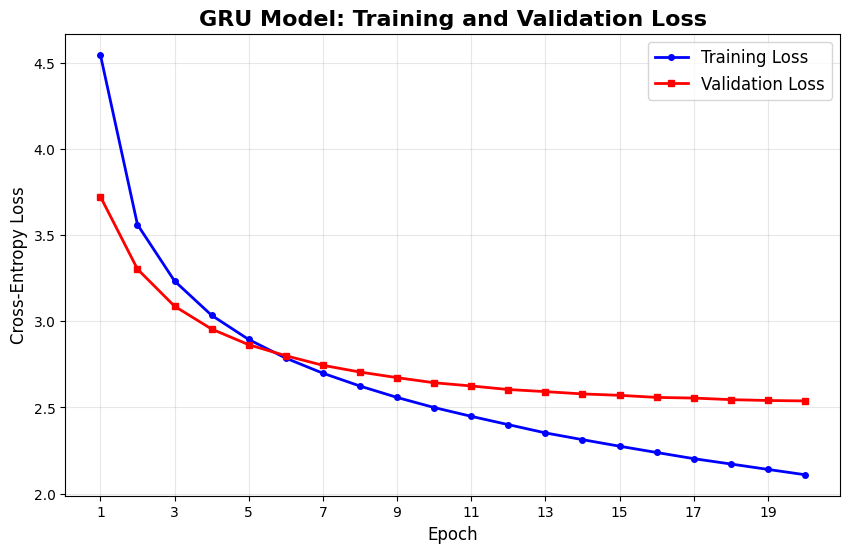

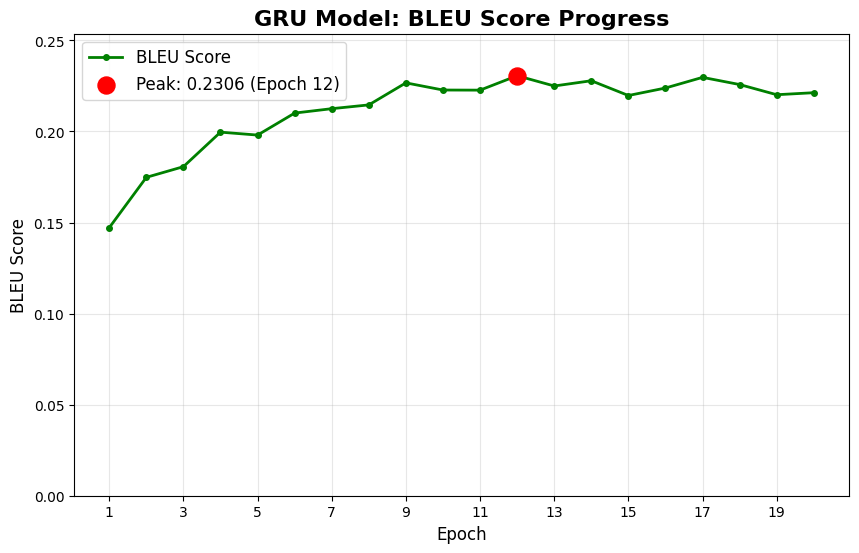

Detailed plots saved to outputs/detailed_loss_plot.png and outputs/detailed_bleu_plot.png
Training complete!


In [16]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training and Validation Loss
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: BLEU Score vs Epoch
ax2.plot(epochs_range, bleu_scores, 'g-', label='BLEU Score', linewidth=2)
# Mark the best BLEU point
if best_bleu > 0:
    ax2.scatter([best_bleu_epoch], [best_bleu], color='red', s=100, zorder=5,
                label=f'Best BLEU: {best_bleu:.4f} at epoch {best_bleu_epoch}')
ax2.set_title('BLEU Score vs Epoch', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('BLEU Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/training_plots.png', dpi=300, bbox_inches='tight')
plt.savefig('outputs/training_plots.pdf', bbox_inches='tight')  # Also save as PDF
plt.close()

print("Training plots saved to outputs/training_plots.png and outputs/training_plots.pdf")

# Create individual detailed plots

# Detailed Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
plt.title('GRU Model: Training and Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(train_losses) + 1, max(1, len(train_losses)//10)))
plt.savefig('outputs/detailed_loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed BLEU Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, bleu_scores, 'g-', label='BLEU Score', linewidth=2, marker='o', markersize=4)
if best_bleu > 0:
    plt.scatter([best_bleu_epoch], [best_bleu], color='red', s=150, zorder=5,
                label=f'Peak: {best_bleu:.4f} (Epoch {best_bleu_epoch})')
plt.title('GRU Model: BLEU Score Progress', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('BLEU Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(bleu_scores) + 1, max(1, len(bleu_scores)//10)))
if len(bleu_scores) > 0:
    plt.ylim(0, max(bleu_scores) * 1.1)  # Set y-axis limits for better visualization
plt.savefig('outputs/detailed_bleu_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Detailed plots saved to outputs/detailed_loss_plot.png and outputs/detailed_bleu_plot.png")

print("Training complete!")